# Example of SSVEP estimators 

In [1]:
import matplotlib.pyplot as plt 
from moabb.datasets import SSVEPExo
from moabb.paradigms import SSVEP
import numpy as np
import pandas as pd 
from pyriemann.classification import MDM
from pyriemann.clustering import Potato
from scipy.stats import norm
import seaborn as sns 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

from utils import extract_epochs
from estimators import SSVEPCovariance, SSVEPPotato

/Users/raph/miniconda3/envs/moabb-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/raph/miniconda3/envs/moabb-env/lib/python3.8/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Read MOABB paradigm and data

In [2]:
paradigm = SSVEP(n_classes=4)
dataset = SSVEPExo()
data = dataset.get_data()
subjects = dataset.subject_list
N = len(subjects)
print(f'Found {N} subjects')
print(f'Found {set([len(data[subject]) for subject in subjects])} sessions per subjects')
print(f'Found {set([len(data[subject]["session_0"]) for subject in subjects])} runs per session')

raw = data[12]['session_0']['run_1']
# check we have all classes we expected
_classes = set()
for subject in subjects:
    for session in data[subject].keys():
        for run in data[subject][session].keys():
            raw = data[subject][session][run]
            X, y, _ = paradigm.process_raw(raw, dataset)
            _classes = set(list(_classes) + list(set(y)))
print(f'Found class {_classes}')

Choosing the first 4 classes from all possible events


Found 12 subjects
Found {1} sessions per subjects
Found {2, 3, 4, 5} runs per session
Found class {'13', 'rest', '17', '21'}


## Classification: SSVEPCovariance + MDM 

In [3]:
# cv split  
run_train = 'run_0'
run_test = 'run_1'

# epoch onset/offset
tmin = 1
tmax = 7

fs = 256
# parameters from SSVEPCovariance
flickering_frequencies = (13, 17, 21)
band_width = 4
order = 2
filter_design = 'iir'
padlen = None

clf = make_pipeline(SSVEPCovariance(fs, flickering_frequencies,'scm', padlen= padlen), MDM())

# for 4 classes 
event_id = {'rest': 1, '13': 2, '17': 3, '21': 4}
acc_scores_4classes = []
for subject in subjects: 
    Xtrain, ytrain = extract_epochs(data[subject]["session_0"][run_train], event_id=event_id, tmin=tmin, tmax=tmax)
    Xtest, ytest = extract_epochs(data[subject]["session_0"][run_test], event_id=event_id, tmin=tmin, tmax=tmax)
    clf.fit(Xtrain, ytrain)
    ypred = clf.predict(Xtest)
    acc_scores_4classes.append(accuracy_score(ypred, ytest))

In [4]:
paper_scores_online = [.688, .646, .812, .833, .729, .667, .931, .875, .604, .646, .542, .525]
df1 = pd.DataFrame(paper_scores_online, columns=['accuracy'], index=subjects)
df1['source'] = 'paper_online'

df2 = pd.DataFrame(acc_scores_4classes, columns=['accuracy'], index=subjects)
df2['source'] = 'mine_4classes'

df = pd.concat([df1, df2], axis=0).reset_index().rename({'index':'subjects'}, axis=1)

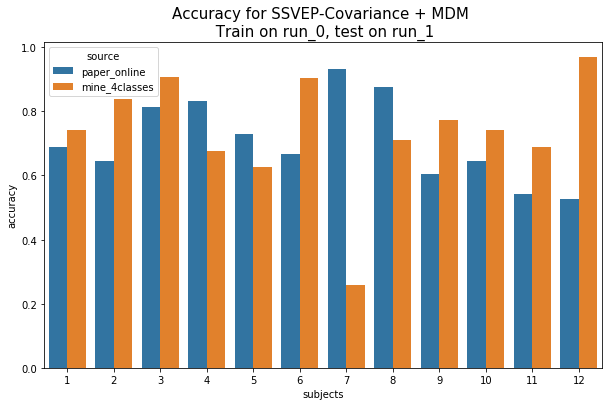

In [5]:
plt.figure(figsize=(10, 6))
sns.barplot(x="subjects", hue="source", y="accuracy", data=df)
plt.title('Accuracy for SSVEP-Covariance + MDM \n Train on run_0, test on run_1', fontsize=15)
plt.show()

## Artifact dectection: Potato or SSVEPPotato

In [6]:
# dataset 
subject = 12 
run_train = 'run_0'
run_test = 'run_1'

# epoch onset/offset
tmin = 1
tmax = 7

# for 4 classes 
event_id = {'rest': 1, '13': 2, '17': 3, '21': 4}

Xtrain, ytrain = extract_epochs(data[subject]["session_0"][run_train], event_id=event_id, tmin=tmin, tmax=tmax)
Xtest, ytest = extract_epochs(data[subject]["session_0"][run_test], event_id=event_id, tmin=tmin, tmax=tmax)


In [7]:
fs = 256
# parameters from SSVEPCovariance
flickering_frequencies = (13, 17, 21)
band_width = 4
order = 2
filter_design = 'iir'
padlen = None


ssvep_covariance = SSVEPCovariance(fs, flickering_frequencies,'scm', padlen  = padlen)
ssvep_potato = SSVEPPotato()
potato = Potato()

# Rejection using single potato 
reject_pipeline_1 = make_pipeline(ssvep_covariance, potato)
z_score_1 = reject_pipeline_1.fit(Xtrain).transform(Xtest)
z_to_p = lambda z_score: 1 - norm.cdf(z_score)
p_score_1 = np.apply_along_axis(z_to_p, 0, z_score_1)
print(f'Test SQI using single potato :\n {p_score_1}')

# Rejection using potato class field 
reject_pipeline_2 = make_pipeline(ssvep_covariance, ssvep_potato)
p_value_2 = reject_pipeline_2.fit(Xtrain, ytrain).transform(Xtest)
print(f'Test SQI using potatoes class field :\n {p_value_2}')


Test SQI using single potato :
 [6.72255335e-02 2.12278774e-01 5.06814707e-02 1.03714916e-04
 1.01493410e-02 2.27071697e-03 2.26257946e-02 1.37862027e-02
 7.72364915e-03 6.70508787e-02 3.42590481e-04 3.07465040e-02
 8.16118721e-02 1.06190849e-03 8.31448844e-03 9.43464025e-03
 1.70319881e-03 7.59240234e-02 4.00220811e-03 2.27175135e-03
 4.81873960e-02 3.62458187e-03 1.05403270e-01 1.72401879e-03
 4.44148872e-03 1.91125270e-05 3.84664583e-03 3.06322114e-03
 3.36188307e-04 6.92967426e-07 8.49139628e-04 9.32752124e-04]
Test SQI using potatoes class field :
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


/Users/raph/PycharmProject/backpack_notebooks/eeg_ssvep_homework/estimators.py:197: RuntimeWarning: divide by zero encountered in log
  q += np.log(np.apply_along_axis(z_to_p, axis=0, arr=z_score))
